In [1]:
#trying to implement an autoencoder using pytorch to reduce the dimensionality of a hyperspectral image pixel from 64 layers to 3 layers
#tensor flow reference: https://www.tensorflow.org/tutorials/generative/autoencoder#:~:text=An%20autoencoder%20is%20a%20special,representation%20back%20to%20an%20image.
# testing with hypertools_cuda_ml docker image 
#using python 3.9 kernel 

# import the necessary packages

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pandas as pd

(4998, 141)
Max value: 7.4021031
Min value: -7.0903741
data type: <class 'numpy.ndarray'> float32


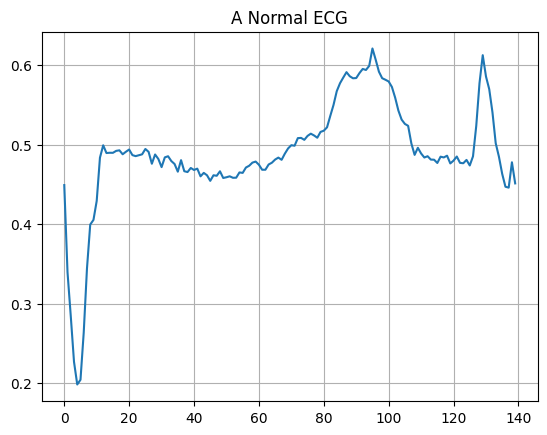

In [8]:
# get the data for the autoencoder
# this is just a test dataset, we will use the hyperspectral image data later

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

print(dataframe.shape)

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

# Normalize the data
max_value = np.amax(data)
min_value = np.amin(data)

print('Max value:', max_value)
print('Min value:', min_value)

normalized_array = (data - min_value) / (max_value - min_value)
normalized_array = normalized_array.astype(np.float32)

print('data type:', type(normalized_array), normalized_array.dtype)

train_data, test_data, train_labels, test_labels = train_test_split(
    normalized_array, labels, test_size=0.3, random_state=21
)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.title("A Normal ECG")
plt.show()

In [21]:
# initialize the model 


# Creating a PyTorch class
# 140 ==> 3 ==> 140
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(140, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 3)
        )
         
       
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 140),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
 
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

train_data shape: (3498, 140)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

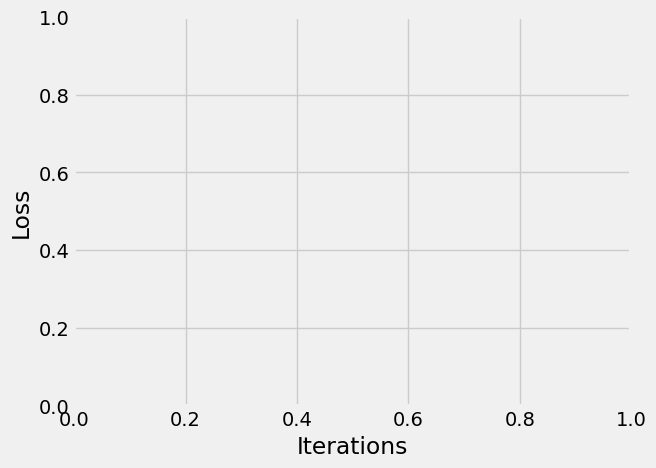

In [22]:
#train the model 


epochs = 20
outputs = []
losses = []

print('train_data shape:', train_data.shape)

for epoch in range(epochs):
    for i, curve in enumerate(train_data):
       
      # Convert the numpy ndarray to a PyTorch Tensor
      curve = torch.from_numpy(curve)
       
      # Output of Autoencoder
      reconstructed = model(curve)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, curve)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, curve, reconstructed))
 



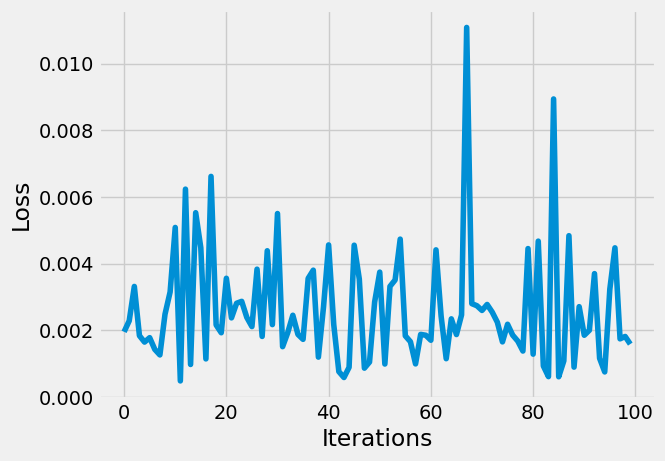

In [25]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
# Detach the Tensor and convert it to a numpy array
losses_np = [loss.detach().numpy() for loss in losses]


# Plotting the last 100 values
plt.plot(losses_np[-100:])
